<a href="https://colab.research.google.com/github/sridevibonthu/EVA/blob/master/S11/Session_11_Assignment_less_than_90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 - Creating Curves

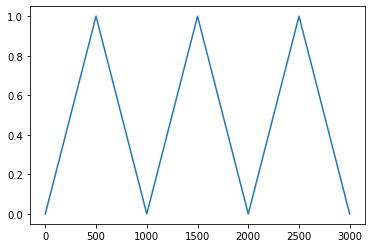

In [1]:
# General Method
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 1, 500)
x = np.concatenate((x, x[::-1],x, x[::-1],x, x[::-1]), axis=None)
y = np.arange(len(x))
plt.plot(y, x)
plt.show()

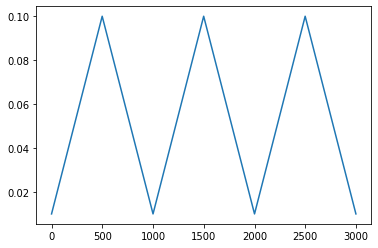

In [2]:
# Method of OneCycleLR
def annealing_linear(start, end, pct):
  return (end - start) * pct + start

steps = 1000
up = float(0.5*steps) - 1
down = float(steps - up) - 1

y = [annealing_linear(0.01, 0.1, x/up) if x<=up else annealing_linear(0.1, 0.01, (x-up)/down) for x in range(steps)] * 3
x = list(range(len(y)))
plt.plot(x,y)
plt.show()

# Import Libraries

In [3]:
!git clone https://github.com/sridevibonthu/EVALibrary.git
import sys
sys.path.append("/content/EVALibrary/EVA4")

fatal: destination path 'EVALibrary' already exists and is not an empty directory.


# Installation of Latest Albumentations Library

In [4]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-uw3z2_pm
All libraries are successfully installed!


In [5]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [6]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
import numpy as np
from eva4datatransforms import AlbumentationTransforms
import albumentations as A
from torchvision import transforms

channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
# Train Phase transformations
train_transforms = AlbumentationTransforms([
                                      A.PadIfNeeded(min_height=40, min_width=40),
                                      A.RandomCrop(32,32),
                                       A.Rotate((-30.0, 30.0)),
                                       A.HorizontalFlip(),
                                       A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=1, max_h_size=8, max_w_size=8) # fillvalue is 0 after normalizing as mean is 0
                                       ])

fillmeans = (np.array(channel_means)).astype(np.uint8)



# Test Phase transformations
test_transforms = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])



# Dataset and Creating Train/Test Split

In [8]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
import eva4dataloaders
batch_size=512

dataloader = eva4dataloaders.DataLoader(batch_size=batch_size)

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 3, 32, 32])
torch.Size([512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


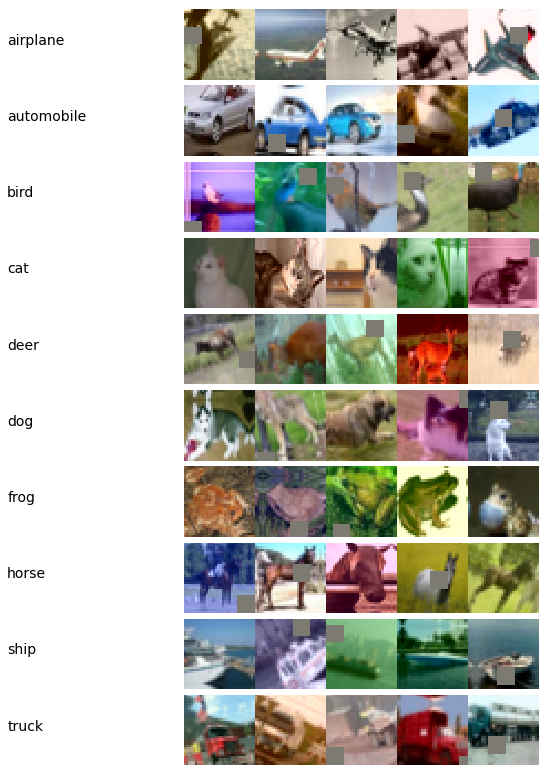

In [10]:
from __future__ import print_function
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)

images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

# Model Creation

We will be calling Resnet18 model here.

We replaced FC with 1x1 as we are not supposed to use FC in this EVA4 library.

In [11]:
from eva4models.S11Model import newResnetS11
import torch
model = newResnetS11()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

## LR Range Test

epoch 0



epoch 1



epoch 2



epoch 3



epoch 4



epoch 5



epoch 6



epoch 7



epoch 8



epoch 9



epoch 10



epoch 11


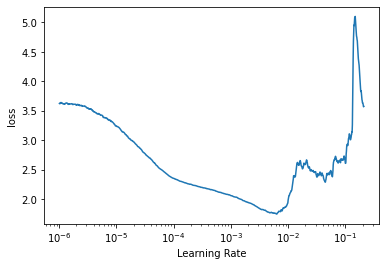

0.00630635334902208


In [13]:
from EVALRRangeFinder import LRRangeFinder 
lrfinder = LRRangeFinder(model=model, epochs=12, start_lr=1e-6, end_lr=0.2, dataloader=train_loader, trainlen=len(train), batch_size=batch_size)
max_lr = lrfinder.findLR()
print(max_lr)

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

One Cycle Policy such that:
* Total Epochs = 24
* Max at Epoch = 5
* LRMIN = LR Finder
* LRMAX = LRMIN/10
* NO Annihilation

In [16]:
model = newResnetS11()
model.to(model.device)

batch_size=512
import torch.optim as optim
#from torch.optim.lr_scheduler import StepLR
#optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.95, weight_decay=1e-4)
L1lambda = 0
L2lambda = 1e-4



EPOCHS = 24
optimizer = optim.SGD(model.parameters(), lr=max_lr, momentum=0.9, nesterov=True, weight_decay=L2lambda)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_loader), div_factor=5, pct_start=0.2, epochs=EPOCHS)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=int(len(train)/batch_size)+1, epochs=EPOCHS,  anneal_strategy='linear', pct_start=(5/24), div_factor=10, final_div_factor=1 )
print("Initial LR- ",scheduler.get_lr())
print("Total steps - ", scheduler.total_steps)
print("No.of steps to increase LR -", scheduler.step_size_up)
print("No.of steps to reduce LR - ", scheduler.step_size_down)

model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, True,L1lambda)

Initial LR-  [0.000630635334902208]
Total steps -  2352
No.of steps to increase LR - 489.0
No.of steps to reduce LR -  1862.0



Validation loss decreased (100000.000000 --> 1.301971).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0035, Accuracy: 35.77%; Test set: Average loss: 1.3020, Accuracy: 53.45%
Learning Rate = 0.001768



Validation loss decreased (1.301971 --> 1.188464).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0026, Accuracy: 52.02%; Test set: Average loss: 1.1885, Accuracy: 58.28%
Learning Rate = 0.002906



Validation loss decreased (1.188464 --> 0.965255).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0022, Accuracy: 59.66%; Test set: Average loss: 0.9653, Accuracy: 66.01%
Learning Rate = 0.004043



Validation loss decreased (0.965255 --> 0.961348).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0020, Accuracy: 63.54%; Test set: Average loss: 0.9613, Accuracy: 67.93%
Learning Rate = 0.005180



Validation loss decreased (0.961348 --> 0.788983).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0019, Accuracy: 67.10%; Test set: Average loss: 0.7890, Accuracy: 73.31%
Learning Rate = 0.006303



Validation loss decreased (0.788983 --> 0.734879).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0017, Accuracy: 70.47%; Test set: Average loss: 0.7349, Accuracy: 74.55%
Learning Rate = 0.006005



Validation loss decreased (0.734879 --> 0.651749).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0015, Accuracy: 73.58%; Test set: Average loss: 0.6517, Accuracy: 77.82%
Learning Rate = 0.005706



Validation loss decreased (0.651749 --> 0.586940).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0014, Accuracy: 75.75%; Test set: Average loss: 0.5869, Accuracy: 80.16%
Learning Rate = 0.005407



Validation loss decreased (0.586940 --> 0.558528).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0013, Accuracy: 77.62%; Test set: Average loss: 0.5585, Accuracy: 80.87%
Learning Rate = 0.005108



Validation loss decreased (0.558528 --> 0.534142).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0012, Accuracy: 79.17%; Test set: Average loss: 0.5341, Accuracy: 82.26%
Learning Rate = 0.004810



Validation loss decreased (0.534142 --> 0.523912).  Saving model ...
Epoch: 11, Train set: Average loss: 0.0011, Accuracy: 80.30%; Test set: Average loss: 0.5239, Accuracy: 82.31%
Learning Rate = 0.004511



Validation loss decreased (0.523912 --> 0.481955).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0011, Accuracy: 81.28%; Test set: Average loss: 0.4820, Accuracy: 83.92%
Learning Rate = 0.004212



Validation loss decreased (0.481955 --> 0.452685).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0010, Accuracy: 82.14%; Test set: Average loss: 0.4527, Accuracy: 84.43%
Learning Rate = 0.003914



Validation loss decreased (0.452685 --> 0.427448).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0010, Accuracy: 83.03%; Test set: Average loss: 0.4274, Accuracy: 85.16%
Learning Rate = 0.003615



Epoch: 15, Train set: Average loss: 0.0009, Accuracy: 83.99%; Test set: Average loss: 0.4280, Accuracy: 85.63%
Learning Rate = 0.003316



Validation loss decreased (0.427448 --> 0.402266).  Saving model ...
Epoch: 16, Train set: Average loss: 0.0009, Accuracy: 84.32%; Test set: Average loss: 0.4023, Accuracy: 86.33%
Learning Rate = 0.003017



Epoch: 17, Train set: Average loss: 0.0008, Accuracy: 85.22%; Test set: Average loss: 0.4150, Accuracy: 85.92%
Learning Rate = 0.002719



Validation loss decreased (0.402266 --> 0.375430).  Saving model ...
Epoch: 18, Train set: Average loss: 0.0008, Accuracy: 85.77%; Test set: Average loss: 0.3754, Accuracy: 87.32%
Learning Rate = 0.002420



Validation loss decreased (0.375430 --> 0.360984).  Saving model ...
Epoch: 19, Train set: Average loss: 0.0008, Accuracy: 86.51%; Test set: Average loss: 0.3610, Accuracy: 87.95%
Learning Rate = 0.002121



Epoch: 20, Train set: Average loss: 0.0007, Accuracy: 86.85%; Test set: Average loss: 0.3706, Accuracy: 87.62%
Learning Rate = 0.001822



Epoch: 21, Train set: Average loss: 0.0007, Accuracy: 87.60%; Test set: Average loss: 0.3657, Accuracy: 87.89%
Learning Rate = 0.001524



Validation loss decreased (0.360984 --> 0.348532).  Saving model ...
Epoch: 22, Train set: Average loss: 0.0007, Accuracy: 87.95%; Test set: Average loss: 0.3485, Accuracy: 88.17%
Learning Rate = 0.001225



Epoch: 23, Train set: Average loss: 0.0007, Accuracy: 88.47%; Test set: Average loss: 0.3625, Accuracy: 87.90%
Learning Rate = 0.000926



Validation loss decreased (0.348532 --> 0.339357).  Saving model ...
Epoch: 24, Train set: Average loss: 0.0006, Accuracy: 88.90%; Test set: Average loss: 0.3394, Accuracy: 88.62%
Learning Rate = 0.000628



In [17]:
print(max(model.stats().train_acc))
print(max(model.stats().test_acc))

0.88902
0.8862


## One Cycle LR (Learning Rate Vs. Iterations)

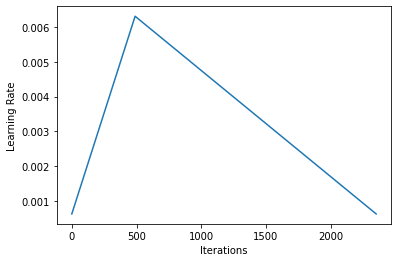

In [18]:
import matplotlib.pyplot as plt
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.plot(model.stats().batch_lr)
plt.xticks(np.arange(0, len(model.stats().batch_lr), step=500))
plt.show()

# Accuracy curves

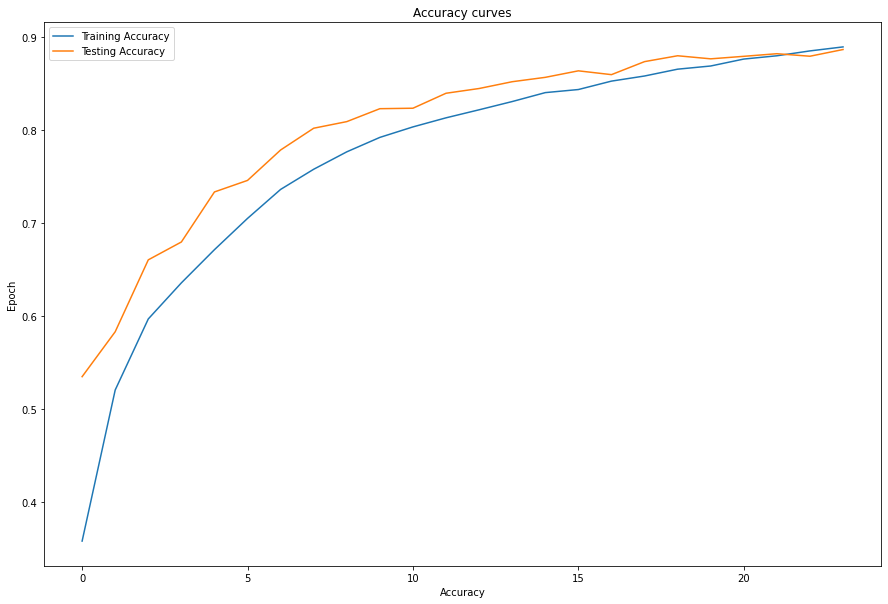

In [19]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model.stats().train_acc)
ax.plot(model.stats().test_acc)

ax.set(title="Accuracy curves", xlabel="Accuracy", ylabel="Epoch")
ax.legend(['Training Accuracy', 'Testing Accuracy'], loc='best')
plt.savefig("TrainTestAccuracy.png")
plt.show()

# Misclassified images

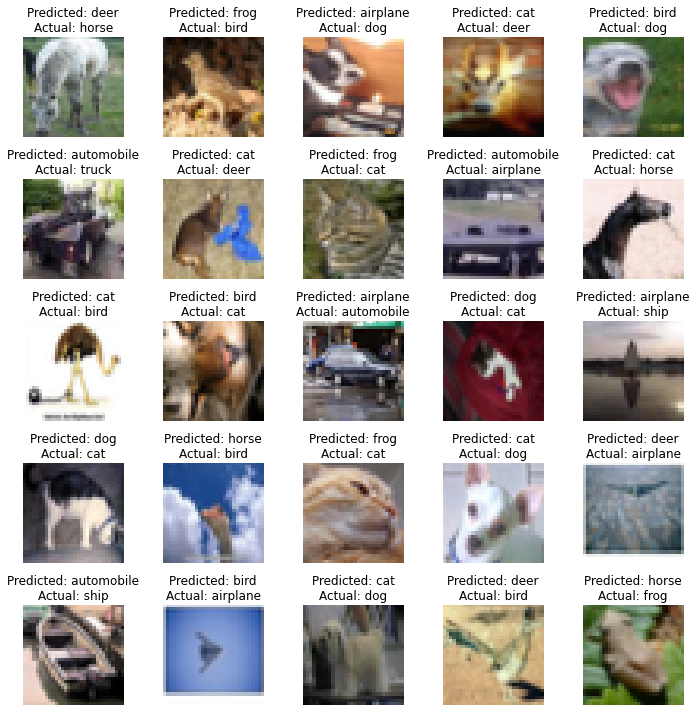

In [20]:

import plots

plots.plot_images(model.stats().get_misclassified_images(), class_names, "misclassified_imgs.png", mean=list(channel_means), std=list(channel_stdevs))
